<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/vgg16_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [88]:
vgg_16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_16.trainable=True

In [89]:
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [51]:
conv3 = tf.keras.models.Model(inputs=vgg_16.input, outputs = vgg_16.get_layer('block3_pool').output)
conv4 = tf.keras.models.Model(inputs=vgg_16.input, outputs = vgg_16.get_layer('block4_pool').output)
conv5 = tf.keras.models.Model(inputs=vgg_16.input, outputs = vgg_16.get_layer('block5_pool').output)

In [52]:
num_classes = 5

#FCN8
architecture from Supervised Classification of Multisensor Remotely
Sensed Images Using a Deep Learning Framework
Sankaranarayanan Piramanayagam 1,*, Eli Saber 1,2, Wade Schwartzkopf 3,†
and Frederick W. Koehler

code by me

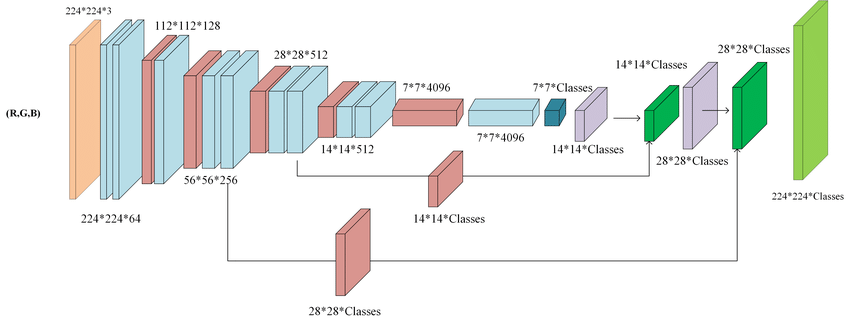

In [232]:
def make_fcn8(input_size = (224,224,3), drop_rate = 0.1):
  input = tf.keras.layers.Input(shape=input_size)
  
  feature_layers = [ vgg_16.get_layer('block3_conv3'), vgg_16.get_layer('block4_conv3'), vgg_16.get_layer('block5_conv3')]
  conv_extractor = tf.keras.models.Model(inputs = vgg_16.input, outputs = [layer.output for layer in feature_layers])
  #w = image width
  #conv_extractor returns list of [(w/4,w/4,256),(w/8,w/8,512),(w/16,w/16,512)] tensors

  features = conv_extractor(input)
  
  x3 = features[0] 
  x3 = tf.keras.layers.MaxPool2D()(x3)
  x3 = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, activation = 'relu', padding = 'same')(x3)
  x3 = tf.keras.layers.Dropout(drop_rate)(x3)
  #(w/4,w/4,num_classes)


  x4 = features[1] #w/8
  x4 = tf.keras.layers.MaxPool2D()(x4)
  x4 = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, activation = 'relu', padding = 'same')(x4)
  x4 = tf.keras.layers.Dropout(drop_rate)(x4)
  #(w/8,w/8,num_classes)

  x5 = features[2] #w/16

  #block6
  x = tf.keras.layers.MaxPool2D()(x5)
  x = tf.keras.layers.Conv2D(4096, kernel_size = 7, activation = 'relu', padding='same')(x)
  #x = tf.keras.layers.Conv2D(4096, kernel_size = 1, activation = 'relu', padding='same')(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)

  #block7
  x = tf.keras.layers.Conv2D(4096, kernel_size = 1, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)
  
  #block8
  x = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, activation = None)(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)
  #(w/16,w/16,num_classes)

  #decoder

  #upsample 1 + skip
  x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size = 4, strides= (2,2),padding='same')(x)
  x = x+x4
  x = tf.keras.layers.Dropout(drop_rate)(x)
  #upsample 2 + skip
  x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size = 4, strides= (2,2),padding='same')(x)
  x= x+x3
  x = tf.keras.layers.Dropout(drop_rate)(x)

  #upsample 3
  x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size = 16, strides= (8,8),padding='same',activation='softmax')(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)




  

  #x = tf.keras.layers.Conv2D(filters = 4096, strides = (2,2))



  return tf.keras.models.Model(inputs = input, outputs = x)

In [233]:
test = make_fcn8()
test.summary()

Model: "model_173"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_88 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_172 (Functional)          [(None, 56, 56, 256) 14714688    input_88[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_127 (MaxPooling2D (None, 7, 7, 512)    0           model_172[0][2]                  
__________________________________________________________________________________________________
conv2d_265 (Conv2D)             (None, 7, 7, 4096)   102764544   max_pooling2d_127[0][0]          
__________________________________________________________________________________________

In [196]:
  feature_layers = [ vgg_16.get_layer('block3_conv3'), vgg_16.get_layer('block4_conv3'), vgg_16.get_layer('block5_conv3')]
  conv_extractor = tf.keras.models.Model(inputs = vgg_16.input, outputs = [layer.output for layer in feature_layers])